### Table of Contents

* [Imports](#chapter1)
    * [Module](#section_1_1)
    * [Electricity data](#section_1_2)
    * [Oil data](#section_1_3)
* [Oil Electricity Correlation](#section_corr)
* [Multivariate Rolling-Window LSTM model](#section_multi_lstm)
* [Deep LSTM model](#section_deep_lstm)
* [Random walk with drift](#section_rand_walk_drift)

#### Module Imports <a class="anchor" id="section_1_1"></a>

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers,Input,Model
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, InputLayer, Bidirectional, Embedding, concatenate
import sklearn.metrics
from itertools import chain
from datetime import timedelta, date
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    """
    function perform Dickey-Fuller test on input timeseries to check whether it is stationary
    :series: a time series as a pandas dataframe
    :column_name: the column name of the column in the series which we are checking
    """
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05: #if the p-value is less than 0.05 we reject the null hypothesis
        print("Conclusion:")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:")
        print("Fail to reject the null hypothesis")
        print("series is non-stationary")

In [4]:
def cointegration_test(df): 
    
    res = coint_johansen(df,-1,2)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

#### Eletricity Data <a class="anchor" id="section_1_2"></a>
Import electricity data. Source: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1057753/CSV_280222.csv/preview

In [3]:
dfe = pd.read_csv("elec_prices_2022",parse_dates = True, delimiter=',', header=0)
dfe['date'] = pd.to_datetime(dfe['date'], format='%d-%m-%Y')
dfe.index = dfe["date"]
print(dfe.dtypes)
del dfe['date']
dfe.head()
elecs_norm = dfe.apply(lambda x:(x-min(x))/(max(x)-min(x)), axis = 0)
print("Number of electricity data points: ",len(elecs_norm))

date       datetime64[ns]
e_price           float64
dtype: object
Number of electricity data points:  517


In [7]:
def denorm(data):
    """
    :param data: numpy array
    :return: numpy array
    """
    min_x = min(dfe['e_price'])
    max_x = max(dfe['e_price'])
    data *= (max_x - min_x)
    data += min_x
    return data

In [107]:
elecs_norm


,e_price
date,
2020-04-02,0.001401
2020-04-03,0.002362
2020-04-06,0.004092
2020-04-07,0.006756
2020-04-08,0.008047
...,...
2022-03-25,0.506152
2022-03-28,0.530896
2022-03-29,0.555888


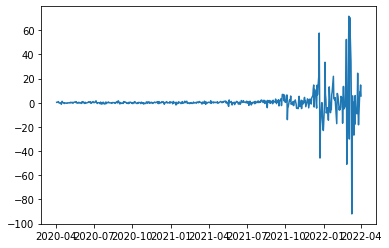

In [108]:
#elec_diff = elecs['Price'].iloc[1:]-elecs['Price'].iloc[:-1]
elec_diff = dfe['e_price']-dfe['e_price'].shift(1)
plt.plot(elec_diff)

In [6]:
Augmented_Dickey_Fuller_Test_func(dfe['e_price'], 'e_price')

Results of Dickey-Fuller Test for column: e_price
Test Statistic                   2.680183
p-value                          0.999086
No Lags Used                    17.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64
Conclusion:
Fail to reject the null hypothesis
series is non-stationary


In [7]:
diff_data = dfe['e_price'].diff().dropna()
Augmented_Dickey_Fuller_Test_func(diff_data, 'e_price')

Results of Dickey-Fuller Test for column: e_price
Test Statistic                -7.864733e+00
p-value                        5.170973e-12
No Lags Used                   1.700000e+01
Number of Observations Used    4.980000e+02
Critical Value (1%)           -3.443549e+00
Critical Value (5%)           -2.867361e+00
Critical Value (10%)          -2.569870e+00
dtype: float64
Conclusion:
Reject the null hypothesis
Data is stationary


below we fit arima model to electricity data

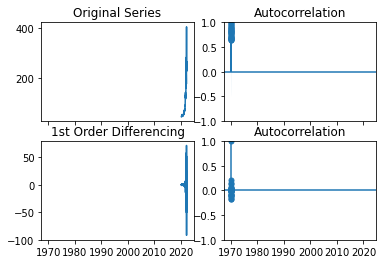

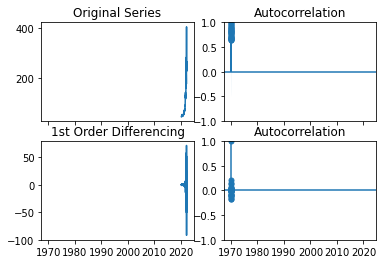

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Original Series
fig, axes = plt.subplots(2, 2, sharex=True)
axes[0, 0].plot(dfe['e_price']); axes[0, 0].set_title('Original Series')
plot_acf(dfe['e_price'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(dfe['e_price'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(dfe['e_price'].diff().dropna(), ax=axes[1, 1])

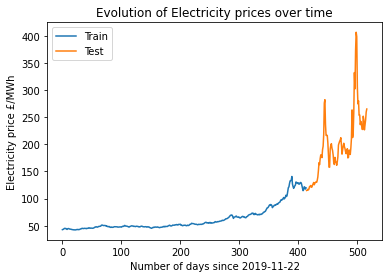

In [26]:
vals = dfe['e_price'].values

plt.plot(vals[:414], label="Train")
plt.plot(np.arange(414,517,1),vals[414:], label="Test")
plt.title("Evolution of Electricity prices over time")
plt.xlabel("Number of days since 2019-11-22")
plt.ylabel("Electricity price £/MWh")
plt.legend()

/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


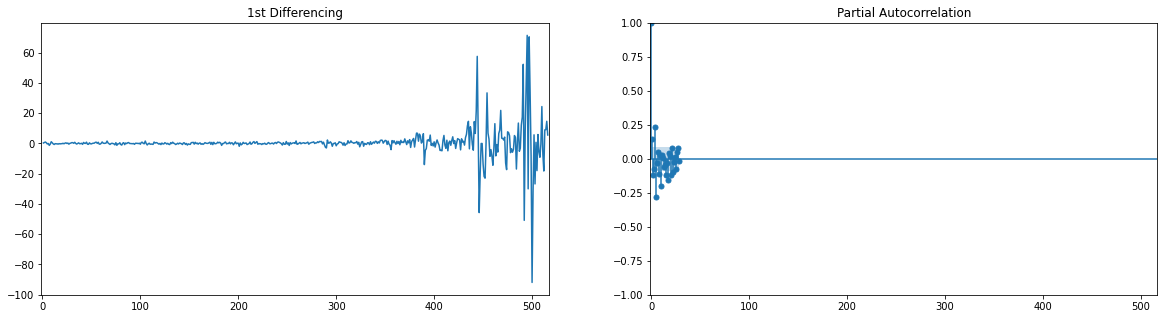

In [14]:
fig, axes = plt.subplots(1, 2, sharex=True)
fig.set_figwidth(20)
fig.set_figheight(5)

axes[0].plot(dfe['e_price'].diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
axes[1].set(xlim=(-1,517))
plot_pacf(dfe['e_price'].diff().dropna().values, ax=axes[1])

plt.show()

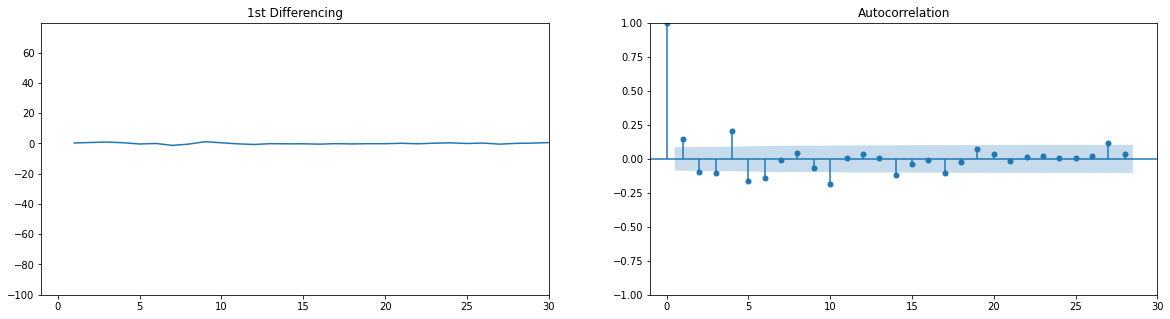

In [115]:
fig, axes = plt.subplots(1, 2, sharex=True)
fig.set_figwidth(20)
fig.set_figheight(5)
axes[0].plot(dfe['e_price'].diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
axes[1].set(xlim=(-1,30))
plot_acf(dfe['e_price'].diff().dropna().values, ax=axes[1])
plt.show()

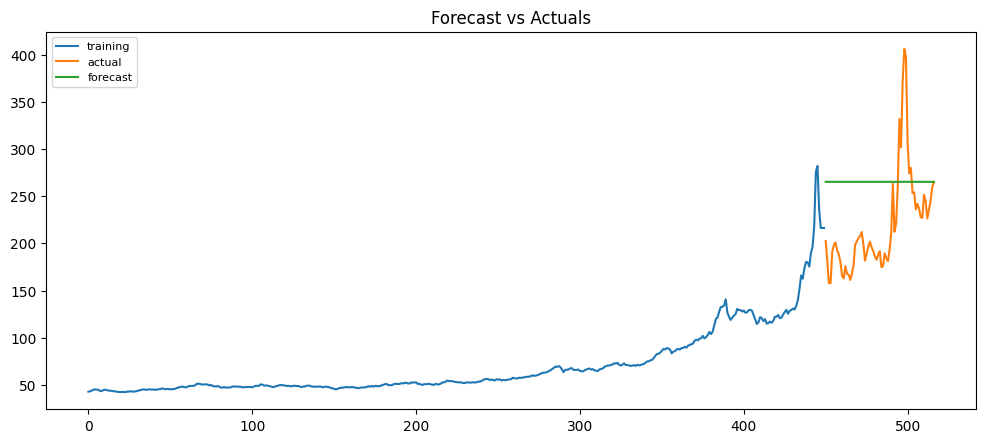

In [116]:
from statsmodels.tsa.arima.model import ARIMA
train = dfe['e_price'].values[:450]
test = dfe['e_price'].values[450:]
# 1,1,2 ARIMA Model
model = ARIMA(dfe['e_price'].values, order=(1,1,1))
fitted = model.fit()
#fc, se, conf = fitted.forecast(517-450, alpha=0.05)  # 95% conf
fc = fitted.forecast(517-450, alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc, index=np.arange(450,517,1))
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)
test_series = pd.Series(test, index = np.arange(450,517,1))
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

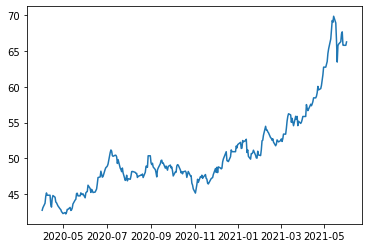

In [117]:
plt.plot(dfe['e_price'].iloc[:300])

In [118]:
# fitted.plot_fitted()

In [119]:
from pmdarima import auto_arima

stepwise_model_elec = auto_arima(dfe['e_price'].diff().iloc[1:450],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2699.832, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2698.808, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2697.832, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.837 seconds


In [120]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# def combine_seasonal_cols(input_df, seasonal_model_results):
#     """Adds inplace new seasonal cols to df given seasonal results
#
#     Args:
#         input_df (pandas dataframe)
#         seasonal_model_results (statsmodels DecomposeResult object)
#     """
#     # Add results to original df
#     input_df['observed'] = seasonal_model_results.observed
#     input_df['residual'] = seasonal_model_results.resid
#     input_df['seasonal'] = seasonal_model_results.seasonal
#     input_df['trend'] = seasonal_model_results.trend
# sd = seasonal_decompose(dfe['e_price'])
# seasonal = pd.Series(dfe['e_price'].values)
# print(seasonal)
# combine_seasonal_cols(seasonal, sd,150)
# seasonal

In [121]:
stepwise_model_elec.predict(steps=3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

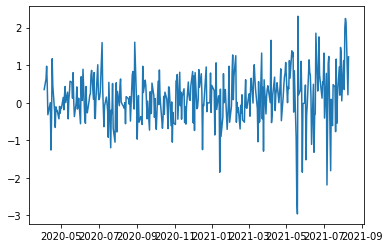

In [122]:
plt.plot(dfe['e_price'].diff().iloc[1:350])

/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-st

<AxesSubplot:xlabel='date'>

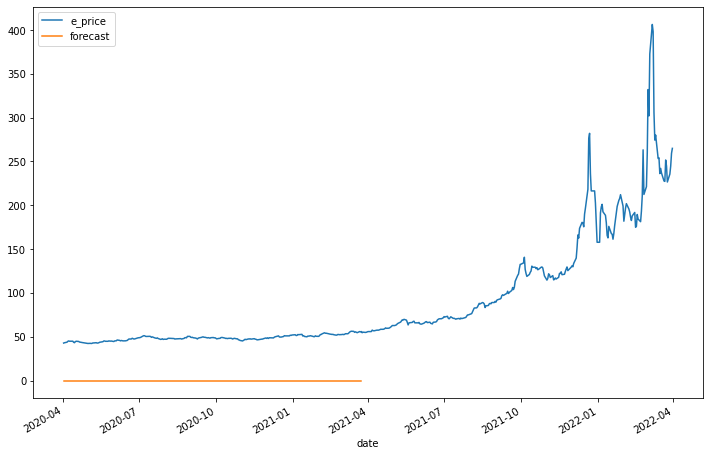

In [123]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(dfe['e_price'].diff().iloc[1:300], order=(20, 1, 10))
res = mod.fit()
res.summary()
dfe['forecast']=res.predict(start=0,end=250,dynamic=True)
dfe[['e_price','forecast']].plot(figsize=(12,8))

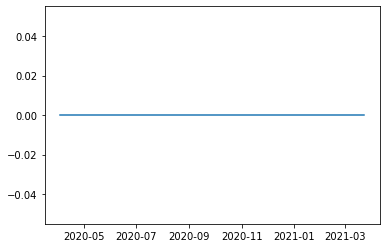

In [124]:
plt.plot(dfe['forecast'])

Create simple
 model to see how it holds up against the data

In [9]:
import keras
observation_size = 5
dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=elecs_norm,
    targets=elecs_norm[observation_size:],
    sequence_length=observation_size,
    batch_size=1,
)
total = elecs_norm.shape[0] - observation_size-1
train_size = (int) (total*0.8)
val_size = (int) (total*0.1)
test_size = total - train_size - val_size
shuffled = dataset#.shuffle(total)
X_train = shuffled.take(train_size)
X_val = shuffled.skip(train_size).take(val_size)
X_test = shuffled.skip(train_size+val_size).take(test_size)


In [6]:
def make_single_lstm(units):
    model = keras.Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(observation_size, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [7]:
def calc_r2(prediction,real,obs_size):
    """
    :param prediction: The forecasted time series
    :param real: The expected time series composed of real observations
    :param obs_size: The window size of
    :return: floating point r2 score <=1
    """
    lstm_diff = prediction.values.reshape(-1,1) - real.iloc[:-1].values.reshape(-1,1)
    temp_diff = real.iloc[1:].values.reshape(-1,1) - real.iloc[:-1].values.reshape(-1,1)
    return sklearn.metrics.r2_score(temp_diff.reshape(-1,1), lstm_diff.reshape(-1,1))

In [21]:
def calc_r2(prediction,real,obs_size):
    """
    :param prediction: The forecasted time series
    :param real: The expected time series composed of real observations
    :param obs_size: The window size of
    :return: floating point r2 score <=1
    """
    lstm_diff = prediction.iloc[1:].values.reshape(-1,1) - prediction.iloc[:-1].values.reshape(-1,1)
    temp_diff = real.iloc[1:].values.reshape(-1,1) - real.iloc[:-1].values.reshape(-1,1)
    return sklearn.metrics.r2_score(temp_diff.reshape(-1,1), lstm_diff.reshape(-1,1))

In [196]:
models = []
bestest_r2 = -10000000000
best_unit = 0
unit_r2s = []
for unit in np.arange(10,200,10):
    best_r2 = -10000000000 # initialised best r2 to be lower than any expected outcome
    best_model = None
    for i in range(1,10):
        model = make_single_lstm(unit)
        history= model.fit(X_train,validation_data=X_val,
                          epochs=10, batch_size=1, verbose=1, shuffle=False)
        pred = pd.Series(model.predict(dataset).ravel())
        new_r2 = calc_r2(pred,dfe['e_price'],observation_size)
        if new_r2 > best_r2:
            best_r2 = new_r2
            best_model = model
    unit_r2s.append(best_r2)
    if best_r2 > bestest_r2:
        bestest_r2 = best_r2
        models.append(best_model)
        best_units = unit

    print("----------Unit complete -------------",(unit))

Epoch 1/10
280/408 [===================>..........] - ETA: 0s - loss: 0.0100

KeyboardInterrupt: 

In [177]:
model.evaluate(dataset)

512/512 [==============================] - 1s 2ms/step - loss: 0.0019


0.001863522338680923

In [10]:
model = make_single_lstm(128)
history= model.fit(X_train,validation_data=X_val,
                  epochs=10, batch_size=1, verbose=1, shuffle=False)
pred = pd.Series(model.predict(dataset).ravel())

Epoch 1/10
408/408 [==============================] - 3s 4ms/step - loss: 1.0546e-04 - val_loss: 0.0171
Epoch 2/10
408/408 [==============================] - 1s 4ms/step - loss: 4.6641e-04 - val_loss: 0.0163
Epoch 3/10
408/408 [==============================] - 2s 4ms/step - loss: 5.7087e-04 - val_loss: 0.0178
Epoch 4/10
408/408 [==============================] - 2s 5ms/step - loss: 5.4805e-04 - val_loss: 0.0181
Epoch 5/10
408/408 [==============================] - 2s 4ms/step - loss: 4.2462e-04 - val_loss: 0.0154
Epoch 6/10
408/408 [==============================] - 2s 4ms/step - loss: 5.0772e-04 - val_loss: 0.0192
Epoch 7/10
408/408 [==============================] - 1s 4ms/step - loss: 4.2574e-04 - val_loss: 0.0147
Epoch 8/10
408/408 [==============================] - 1s 3ms/step - loss: 4.6604e-04 - val_loss: 0.0132
Epoch 9/10
408/408 [==============================] - 1s 3ms/step - loss: 4.3270e-04 - val_loss: 0.0132
Epoch 10/10
408/408 [==============================] - 1s 3ms/st

(512,)
(517, 1)


-23.58742752438619

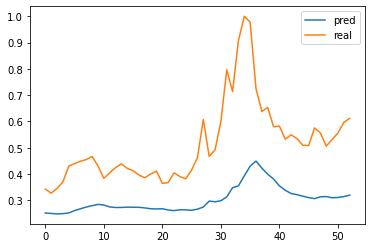

In [67]:
print(pred.shape)
print(elecs_norm.shape)
plt.plot(pred[train_size+val_size:].values,label='pred')
plt.plot(elecs_norm[observation_size+train_size+val_size:].values,label='real')
plt.legend()
sklearn.metrics.r2_score(pred[train_size+val_size:],elecs_norm[observation_size+train_size+val_size:])

The predicted data is plotted below

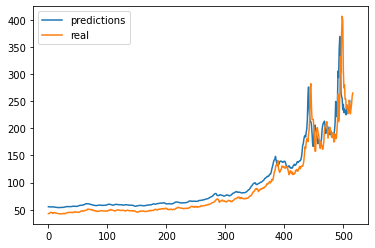

In [190]:
#plt.plot(dfe['e_price'].values)
pred = pd.Series(model.predict(dataset).ravel())
plt.plot(denorm(pred), label="predictions")
plt.plot(dfe['e_price'].values, label="real")
plt.legend()

In [191]:
calc_r2(pred,dfe['e_price'],observation_size)

-0.953449196198092

In [182]:
#lstm_diff =pred.values.reshape(-1,1) - elecs_norm['e_price'].iloc[observation_size-1:-1].values.reshape(-1,1)
#temp_diff = elecs_norm['e_price'].iloc[observation_size:].values.reshape(-1,1)-elecs_norm['e_price'].iloc[observation_size-1:-1].values.reshape(-1,1)
lstm_diff = pred.values.reshape(-1,1) - elecs_norm['e_price'].shift(1).iloc[observation_size:].values.reshape(-1,1)
temp_diff = elecs_norm['e_price'].iloc[observation_size:].values.reshape(-1,1) - elecs_norm['e_price'].shift(1).iloc[observation_size:].values.reshape(-1,1)

It seems to be slightly worse than the temperature data

In [183]:
sklearn.metrics.r2_score(temp_diff.reshape(-1,1), lstm_diff)

-21978103.005503975

In [135]:
def daterange(date1, date2):
    """
    function generates dates between two bounds each a week apart
    """
    yield (date1 + timedelta(n) for n in range(0,int ((date2 - date1).days)+1,7))

o_price            float64
Open                 int64
High                 int64
Low                  int64
Volume               int64
Estimate             int64
date        datetime64[ns]
dtype: object
             o_price
date                
2017-01-16  0.336217
2017-01-17  0.332628
2017-01-18  0.318362
2017-01-19  0.320571
2017-01-20  0.332812
...              ...
2022-05-09  0.797147
2022-05-10  0.765117
2022-05-11  0.811597
2022-05-12  0.811045
2022-05-13  0.848780

[1386 rows x 1 columns]


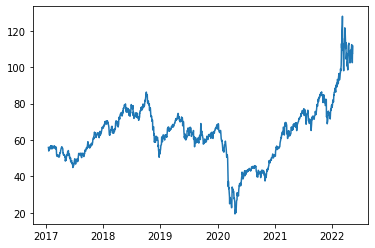

In [28]:
# all_oil_prices = pd.read_csv('wfuel_prices.csv',
#                        #index_col ='Date',
#                        parse_dates = True, delimiter=',', header=0)
# start_dt = date(2021,2,1)
# end_dt = date(2021,12,27)
# oil_prices = all_oil_prices.iloc[-57:-9]
#
# oil_prices.loc[:,('ULSP')] = oil_prices['ULSP'].apply(float)
dfo = pd.read_json("brent_crude_prices.json",  lines = True)
dfo.rename(columns = {'Date':'date', 'Close':'o_price'}, inplace = True)
dfo.index = dfo["date"]
print(dfo.dtypes)
del dfo['date']
del dfo['Open']
del dfo['High']
del dfo['Low']
del dfo['Volume']
del dfo['Estimate']

oil_norms = pd.DataFrame(dfo['o_price']).apply(lambda x:((x-min(x))/(max(x)-min(x))))#, axis = 0)
print(oil_norms)
plt.plot(dfo['o_price'])


In [11]:
def create_window(data,win_size):
    """
    create rolling window
    assume win_size < len(data)
    """
    window_data = []
    for i in range(len(data) - win_size+1):
        window_data.append(data[i:i+win_size])
    return window_data

We fix the indexing of the oil data

In [29]:
electricity_prices = elecs_norm['e_price'].values
oil_prices_list = oil_norms['o_price'].values
#dates = list(chain.from_iterable(daterange(start_dt,end_dt)))
df1 = pd.DataFrame(electricity_prices,columns=['e_price'])#,index=dates)
df1 = pd.merge_asof(elecs_norm['e_price'], oil_norms['o_price'], on="date",
                                 by="date")
del df1['date']

df1.head()

,e_price,o_price
0,0.001401,0.097653
1,0.002362,0.136033
2,0.004092,0.126277
3,0.006756,0.115416
4,0.008047,0.124344


***

### Correlation <a class="anchor" id="section_corr"></a>
We create a heatmap with the correlation of each timeseries in the dataframe

/var/folders/2x/r7stqt9j3ys7q29zxm50kcv40000gn/T/ipykernel_34407/3928516402.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<AxesSubplot:>

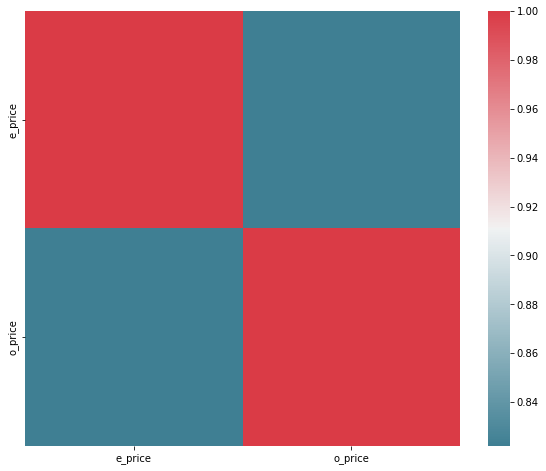

In [13]:
import seaborn as sns
corr = df1.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [140]:
print(corr)

          e_price   o_price
e_price  1.000000  0.822097
o_price  0.822097  1.000000


Create the data structure to train the model on

In [14]:
window_size = 10
window_elec = create_window(electricity_prices,window_size)
window_oil = create_window(oil_prices_list,window_size)

new_list = []
for i in range(len(window_elec)):
    a1 = np.array(window_elec[i])
    a2 = np.array(window_oil[i])
    a3 = [a1,a2]
    new_list.append(a3)

***

### Multivariate rolling window LSTM model <a class="anchor" id="section_multi_lstm"></a>
LSTM model to train on the electricity and oil data (multivariate input)

In [70]:
observation_size = 10
dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=elecs_norm,
    targets=elecs_norm[observation_size:],
    sequence_length=observation_size,
    batch_size=1,
)
X_train = dataset.take(train_size+val_size)
X_test = dataset.skip(train_size+val_size).take(test_size)

In [73]:
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, activation='relu', input_shape=(observation_size,1), return_sequences=False),
        tf.keras.layers.Dense(1)
    ], name='lstm')
model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train,  validation_data = X_test,
                  epochs=10, batch_size=1, verbose=1, shuffle=False)

Epoch 1/10
459/459 [==============================] - 4s 5ms/step - loss: 7.3399e-04 - val_loss: 0.0560
Epoch 2/10
459/459 [==============================] - 2s 4ms/step - loss: 0.0017 - val_loss: 0.0554
Epoch 3/10
459/459 [==============================] - 2s 4ms/step - loss: 0.0015 - val_loss: 0.0475
Epoch 4/10
459/459 [==============================] - 2s 4ms/step - loss: 0.0015 - val_loss: 0.0321
Epoch 5/10
459/459 [==============================] - 2s 5ms/step - loss: 0.0011 - val_loss: 0.0358
Epoch 6/10
459/459 [==============================] - 2s 4ms/step - loss: 0.0013 - val_loss: 0.0281
Epoch 7/10
459/459 [==============================] - 2s 5ms/step - loss: 8.0513e-04 - val_loss: 0.0297
Epoch 8/10
459/459 [==============================] - 2s 5ms/step - loss: 9.8531e-04 - val_loss: 0.0266
Epoch 9/10
459/459 [==============================] - 2s 5ms/step - loss: 8.4442e-04 - val_loss: 0.0264
Epoch 10/10
459/459 [==============================] - 2s 5ms/step - loss: 7.0655e-0

In [81]:
def calc_r22(prediction,real,obs_size):
    """
    :param prediction: The forecasted time series
    :param real: The expected time series composed of real observations
    :param obs_size: The window size of
    :return: floating point r2 score <=1
    """
    lstm_diff = prediction.values.reshape(-1,1) - real.iloc[:-1].values.reshape(-1,1)
    #mask = np.all(np.isnan(lstm_diff),axis=1)
    #lstm_diff = lstm_diff[~mask].reshape(-1,1)
    temp_diff = real.iloc[1:].values.reshape(-1,1) - real.iloc[:-1].values.reshape(-1,1)
    #mask = np.all(np.isnan(temp_diff),axis=1)
    #temp_diff = temp_diff[~mask].reshape(-1,1)
    return sklearn.metrics.r2_score(temp_diff.reshape(-1,1), lstm_diff.reshape(-1,1))

-0.019570226311112826
-3.96206335739347


-0.13458101218819696

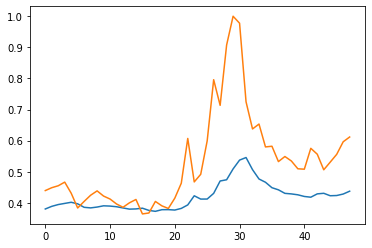

In [83]:
pred = model.predict(X_test)
plt.plot(pred)
plt.plot(elecs_norm[observation_size+train_size+val_size:].values)
print(calc_r2(pd.Series(pred.ravel()),elecs_norm[observation_size+train_size+val_size:],0))
print(calc_r22(pd.Series(pred.ravel()),elecs_norm[observation_size+train_size+val_size-1:],0))
sklearn.metrics.r2_score(elecs_norm[observation_size+train_size+val_size:],pred)

Calculate the predictions and differences

In [209]:
#We use the first #window_size number of elements to predict the next element in the series
#so the first element to be predicted will be window_size th element starting from 0.
lstm_pred = model.predict(np.array(new_list))
#print(lstm_pred.shape)
calc_r2(pd.Series(lstm_pred.ravel()[:-1]),dfe['e_price'],window_size)
# start_slice = elecs_norm['e_price'].iloc[window_size-1:-1].values.reshape(-1,1)
# lstm_diff = lstm_pred[:-1].reshape(-1,1) - start_slice
# print(lstm_diff.shape)
# elec_diff = elecs_norm['e_price'].iloc[window_size:].values.reshape(-1,1) - start_slice
# score = sklearn.metrics.r2_score(elec_diff.reshape(-1,1), lstm_diff.reshape(-1,1))
# score

-137.3138936660079

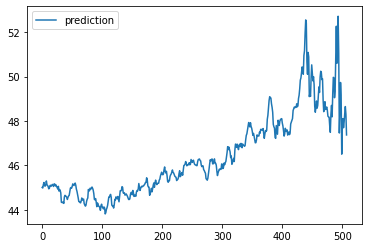

In [210]:
plt.plot(denorm(lstm_pred), label='prediction')
#plt.plot(dfe['e_price'].values, label='real')
#plt.plot((pred),label='univariate')
plt.legend()

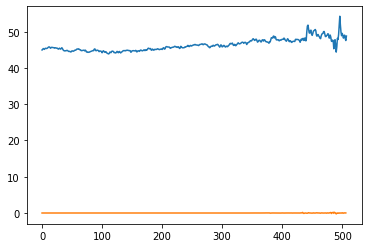

In [167]:
plt.plot(lstm_pred)
plt.plot(elec_diff)

Plot the differences

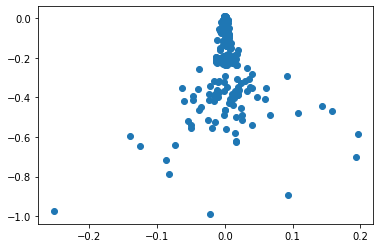

In [168]:
plt.plot(elec_diff,lstm_diff, 'o')

***

#### Deep LSTM model<a class="anchor" id="section_deep_lstm"></a>

In [60]:
df1 = df1.diff().dropna()

dataset = tf.keras.utils.timeseries_dataset_from_array(
        data=df1,
        targets=df1.iloc[10:,0],
        sequence_length=10,
        batch_size=1
)
X_train = dataset.take(train_size)
X_val = dataset.skip(train_size).take(val_size)
X_test = dataset.skip(train_size+val_size).take(test_size)

In [61]:
window_size=10
model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(None,2)),
        tf.keras.layers.LSTM(256, activation='relu', input_shape=(window_size,2), return_sequences=True),
        #RepeatVector(2),
        #tf.keras.layers.LSTM(256, activation='relu', input_shape=(2, window_size), return_sequences=True),
        tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=False),
        #TimeDistributed(tf.keras.layers.Dense(1))
        tf.keras.layers.Dense(1),
        #RepeatVector(1)
    ], name='lstm')

model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train,validation_data=X_val,
                  epochs=15, batch_size=1, verbose=1, shuffle=False)

Epoch 1/15
408/408 [==============================] - 11s 19ms/step - loss: 2.3120e-05 - val_loss: 0.0017
Epoch 2/15
408/408 [==============================] - 7s 18ms/step - loss: 2.1819e-05 - val_loss: 0.0017
Epoch 3/15
408/408 [==============================] - 7s 18ms/step - loss: 2.1506e-05 - val_loss: 0.0017
Epoch 4/15
408/408 [==============================] - 7s 18ms/step - loss: 2.1440e-05 - val_loss: 0.0017
Epoch 5/15
408/408 [==============================] - 8s 20ms/step - loss: 2.1408e-05 - val_loss: 0.0017
Epoch 6/15
408/408 [==============================] - 7s 18ms/step - loss: 2.1392e-05 - val_loss: 0.0017
Epoch 7/15
408/408 [==============================] - 6s 14ms/step - loss: 2.1382e-05 - val_loss: 0.0017
Epoch 8/15
408/408 [==============================] - 6s 14ms/step - loss: 2.1376e-05 - val_loss: 0.0017
Epoch 9/15
408/408 [==============================] - 6s 15ms/step - loss: 2.1372e-05 - val_loss: 0.0017
Epoch 10/15
408/408 [==============================] -

-1.781425321256691e-06

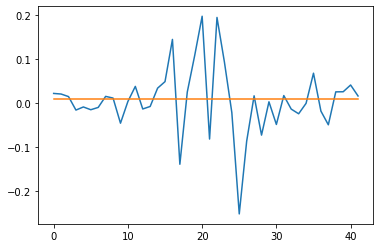

In [65]:
#We use the first #window_size number of elements to predict the next element in the series
#so the first element to be predicted will be window_size th element starting from 0.
lstm_pred = df1['e_price'][train_size+val_size+window_size] + model.predict((X_test))
#print(lstm_pred)
plt.plot(df1['e_price'][train_size+val_size+window_size:].values)
plt.plot(lstm_pred)
calc_r2(pd.Series(lstm_pred.ravel()),df1['e_price'][train_size+val_size+window_size:],0)
# start_slice = elecs_norm['e_price'].iloc[window_size-1:-1].values.reshape(-1,1)
# lstm_diff = lstm_pred[:-1].reshape(-1,1) - start_slice
# #print(lstm_diff.shape)
# elec_diff = elecs_norm['e_price'].iloc[window_size:].values.reshape(-1,1) - start_slice
# score = sklearn.metrics.r2_score(elec_diff.reshape(-1,1), lstm_diff.reshape(-1,1))
# score

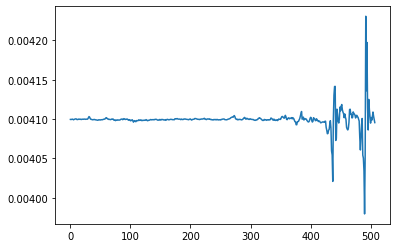

In [171]:
plt.plot(lstm_pred)

Bidirectional LSTM

In [223]:
lstm_pred = model.predict(np.array(new_list))
calc_r2(pd.Series(lstm_pred.ravel()[:-1]),dfe['e_price'],window_size)

-137.3352470976324

In [224]:
model1 = tf.keras.models.Sequential([
        (tf.keras.layers.LSTM(50, activation='relu', input_shape=(2, window_size), return_sequences=True)),
        #RepeatVector(2),
        tf.keras.layers.LSTM(50, activation='relu', input_shape=(2, window_size), return_sequences=False), 
        
        #TimeDistributed(tf.keras.layers.Dense(1))
        tf.keras.layers.Dense(1),
        #RepeatVector(1)
    ], name='lstm')
model1.compile(loss='mse', optimizer='adam')
hist = model1.fit(np.array(new_list[:30]), electricity_prices[window_size:30+window_size],
                  epochs=15, batch_size=1, verbose=1, shuffle=False)
lstm_pred = model1.predict(np.array(new_list))
calc_r2(lstm_pred[:-1],window_size)

# hist2 = model1.fit(errors[:30], electricity_prices[window_size:30+window_size],
#                   epochs=15, batch_size=1, verbose=1, shuffle=False)
# lstm_pred2 = model1.predict(np.array(new_list))
# calc_R2(lstm_pred2[:-1],window_size)

Epoch 1/15
30/30 [==============================] - 2s 2ms/step - loss: 4.1905e-06
Epoch 2/15
30/30 [==============================] - 0s 2ms/step - loss: 4.5330e-06
Epoch 3/15
30/30 [==============================] - 0s 2ms/step - loss: 6.1905e-06
Epoch 4/15
30/30 [==============================] - 0s 2ms/step - loss: 1.0026e-05
Epoch 5/15
30/30 [==============================] - 0s 2ms/step - loss: 2.2077e-05
Epoch 6/15
30/30 [==============================] - 0s 2ms/step - loss: 2.9947e-05
Epoch 7/15
30/30 [==============================] - 0s 2ms/step - loss: 1.6892e-05
Epoch 8/15
30/30 [==============================] - 0s 3ms/step - loss: 2.7522e-05
Epoch 9/15
30/30 [==============================] - 0s 3ms/step - loss: 3.5736e-05
Epoch 10/15
30/30 [==============================] - 0s 3ms/step - loss: 3.2176e-05
Epoch 11/15
30/30 [==============================] - 0s 2ms/step - loss: 2.7195e-05
Epoch 12/15
30/30 [==============================] - 0s 2ms/step - loss: 2.4833e-05
E

-69.70237821465943

In [226]:
errors = lstm_pred[:-1] - elecs_norm['e_price'].iloc[window_size:].values.reshape(-1,1)
model1 = tf.keras.models.Sequential([
        (tf.keras.layers.LSTM(50, activation='relu', input_shape=(1,1), return_sequences=True)),
        #RepeatVector(2),
        #tf.keras.layers.LSTM(50, activation='relu', input_shape=(1,1), return_sequences=False), 
        
        #TimeDistributed(tf.keras.layers.Dense(1))
        tf.keras.layers.Dense(1),
        #RepeatVector(1)
    ], name='lstm')
model1.compile(loss='mse', optimizer='adam')
print(electricity_prices[window_size:30+window_size].shape)
print(errors.shape)
hist2 = model1.fit(errors[:30], electricity_prices[1:31],
                   epochs=15, batch_size=1, verbose=1, shuffle=False)

lstm_pred2 = model1.predict(electricity_prices.reshape(-1,1))

calc_r2(pd.Series(lstm_pred2[:-1].ravel()),dfe['e_price'],1)

(30,)
(507, 1)
Epoch 1/15
30/30 [==============================] - 1s 2ms/step - loss: 8.1097e-06
Epoch 2/15
30/30 [==============================] - 0s 2ms/step - loss: 1.5192e-05
Epoch 3/15
30/30 [==============================] - 0s 2ms/step - loss: 1.9066e-05
Epoch 4/15
30/30 [==============================] - 0s 2ms/step - loss: 1.5646e-05
Epoch 5/15
30/30 [==============================] - 0s 2ms/step - loss: 1.4687e-05
Epoch 6/15
30/30 [==============================] - 0s 2ms/step - loss: 1.4814e-05
Epoch 7/15
30/30 [==============================] - 0s 2ms/step - loss: 1.4869e-05
Epoch 8/15
30/30 [==============================] - 0s 3ms/step - loss: 1.4868e-05
Epoch 9/15
30/30 [==============================] - 0s 2ms/step - loss: 1.4867e-05
Epoch 10/15
30/30 [==============================] - 0s 2ms/step - loss: 1.4869e-05
Epoch 11/15
30/30 [==============================] - 0s 2ms/step - loss: 1.4870e-05
Epoch 12/15
30/30 [==============================] - 0s 2ms/step - los

-137.74076059296326

In [227]:
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model = tf.keras.models.Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(2, window_size)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, input_shape=(2, window_size), activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
hist = model.fit(np.array(new_list[:30]), electricity_prices[window_size:30+window_size],
                  epochs=15, batch_size=1, verbose=1, shuffle=False)
lstm_pred = model1.predict(np.array(new_list))
calc_r2(pd.Series(lstm_pred[:-1].ravel()),dfe['e_price'],1)

ValueError: Exception encountered when calling layer "time_distributed_1" (type TimeDistributed).

Input 0 of layer "conv1d_1" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 10)

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 2, 10), dtype=float32)
  • training=None
  • mask=None

VARMA model

In [229]:
dfe_log = np.log(dfe)
dfo_log = np.log(dfo)

In [230]:
from pmdarima import auto_arima
stepwise_model_elec = auto_arima(dfe_log['e_price'].iloc[400:450],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-148.953, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-140.913, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-145.311, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-150.774, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-141.141, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-149.062, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-147.794, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-151.887, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-149.967, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-150.003, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-146.523, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-148.258, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.006 seconds


In [231]:
from pmdarima import auto_arima
stepwise_model_oil = auto_arima(dfo_log['o_price'].iloc[400:450],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-286.387, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-290.169, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-288.188, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-288.201, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-290.434, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.463 seconds


In [242]:
from statsmodels.tsa.statespace.varmax import VARMAX
# diff = (pd.DataFrame(electricity_prices).diff().to_numpy())
# diff2 = (pd.DataFrame(oil_prices_list).diff().to_numpy())
# print(diff.shape)
# var_model1 = VARMAX(pd.DataFrame([diff[1:30],diff2[1:30]]),order=(0,1)).fit()
# result = model.forecast(steps = 18)
electricity_prices_diff = dfe_log['e_price'].diff().iloc[1:]
print(electricity_prices.shape)
oil_prices_list_diff = dfo_log['o_price'].diff().iloc[1:]
print(oil_prices_list.shape)
#dates_diff = list(chain.from_iterable(daterange(start_dt,end_dt)))

df2 = pd.merge_asof(electricity_prices_diff, oil_prices_list_diff, on="date",
                                  by="date")
del df2['date']
df2 = df2.dropna()
print(df2.head())
var_model1 = VARMAX(df2.iloc[400:450,:],order=(0,1)).fit(disp=False)
var_model2 = VARMAX(df2.iloc[400:450,:],order=(1,1)).fit(disp=False)
result = var_model1.forecast(steps = 59)
result2 = var_model2.forecast(steps = 59)

(517,)
(1386,)
    e_price   o_price
0  0.008152  0.130395
1  0.014508 -0.031569
2  0.021934 -0.036356
3  0.010457  0.029982
4 -0.007108 -0.042295


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided an

In [243]:
print(result2)

      e_price   o_price
50  -0.037979 -0.009450
51   0.013293  0.002703
52   0.005897 -0.001389
53   0.007433 -0.000811
54   0.007169 -0.000933
55   0.007219 -0.000912
56   0.007210 -0.000916
57   0.007212 -0.000915
58   0.007211 -0.000915
59   0.007211 -0.000915
60   0.007211 -0.000915
61   0.007211 -0.000915
62   0.007211 -0.000915
63   0.007211 -0.000915
64   0.007211 -0.000915
65   0.007211 -0.000915
66   0.007211 -0.000915
67   0.007211 -0.000915
68   0.007211 -0.000915
69   0.007211 -0.000915
70   0.007211 -0.000915
71   0.007211 -0.000915
72   0.007211 -0.000915
73   0.007211 -0.000915
74   0.007211 -0.000915
75   0.007211 -0.000915
76   0.007211 -0.000915
77   0.007211 -0.000915
78   0.007211 -0.000915
79   0.007211 -0.000915
80   0.007211 -0.000915
81   0.007211 -0.000915
82   0.007211 -0.000915
83   0.007211 -0.000915
84   0.007211 -0.000915
85   0.007211 -0.000915
86   0.007211 -0.000915
87   0.007211 -0.000915
88   0.007211 -0.000915
89   0.007211 -0.000915
90   0.007211 -0

Plot the results of the VARMA model below

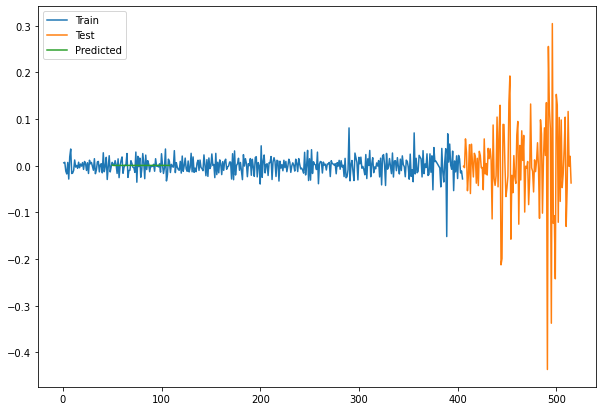

AttributeError: 'Line2D' object has no property 'index'

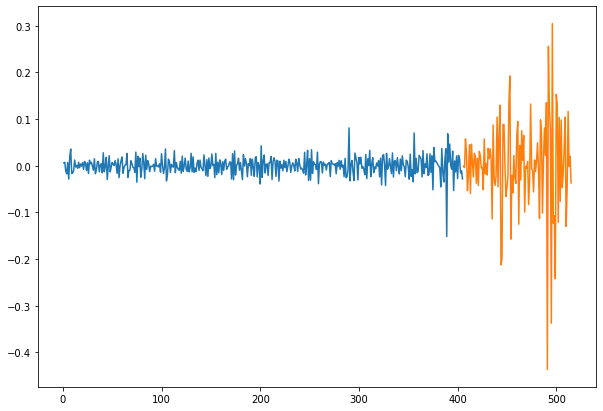

In [240]:
plt.rcParams["figure.figsize"] = [10,7]
plt.plot( df2['e_price'].iloc[:400], label='Train')
plt.plot(df2['e_price'].iloc[400:], label='Test')
plt.plot(result['e_price'], label='Predicted')
plt.legend(loc='best')
plt.show()

plt.rcParams["figure.figsize"] = [10,7]
plt.plot( df2['e_price'].iloc[:400], label='Train')
plt.plot(df2['e_price'].iloc[400:], label='Test')
plt.plot(result2['e_price'], label='Predicted', index=np.arange(450,509,1))
plt.legend(loc='best')
plt.show()

It can be seen that the model is not very good at predicting shock

In [ ]:
plt.plot(result['e_price'][:20])

In [241]:
calc_r2(result2['e_price'], df2['e_price'].iloc[450:], 1)

0.6504275924750005

***

In [ ]:
elec_log = np.log(dfe['e_price'])
mu = np.mean((elec_log-elec_log.shift(1))[:30])

print("mu:", mu)
rwd_prices = mu*np.arange(0,elec_log.shape[0],1) + elec_log[0]

plt.plot(rwd_prices)
plt.plot(elec_log.values)
plt.legend()
plt.plot(elec_log)

In [ ]:
white_noise = elec_log - rwd_prices
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(256, activation='relu', input_shape=(2, 1), return_sequences=True),
        #RepeatVector(2),
        tf.keras.layers.LSTM(128, activation='relu', input_shape=(2, 1), return_sequences=False),    
        #TimeDistributed(tf.keras.layers.Dense(1))
        tf.keras.layers.Dense(1),
        #RepeatVector(1)
    ], name='lstm')
model.compile(loss='mse', optimizer='adam')
hist = model.fit(elec_log[:30], white_noise[10:40],
                  epochs=15, batch_size=1, verbose=1, shuffle=False)

In [ ]:
white_noise_pred = model.predict(elec_log)
print(white_noise_pred)
plt.plot(rwd_prices + white_noise_pred.ravel())
plt.plot(elec_log.values)
plt.legend()
plt.plot(elec_log)

Kalman Filtering

In [15]:
eo_cov = df1["o_prices"].cov(df1["e_prices"])

KeyError: 'o_prices'

In [ ]:
elec_variance = df1["e_prices"].var()
oil_variance = df1["o_prices"].var()

In [ ]:
from filterpy.kalman import KalmanFilter
f = KalmanFilter (dim_x=2, dim_z=1)
f.x = np.array([1.,1.])
f.F = np.array([[1.,1.],[1.,1.]])
f.H = np.array([[1.,0.]])
f.P = np.array([[elec_variance,    eo_cov],[eo_cov,    oil_variance]])
f.R = 5
from filterpy.common import Q_discrete_white_noise
f.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=0.13)
f.predict()
f.update(np.array([df1["e_prices"].iloc[0]]))

In [ ]:
arr1 = []
plt.plot(df1["e_prices"].shift(-1))
for i in range(electricity_prices.shape[0]):
    f.update(np.array([i]))
    arr1.append(electricity_prices[i]*f.x[0]+oil_prices_list[i]*f.x[1])
plt.plot(arr1)

In [ ]:
arr = (electricity_prices*f.x[0]+oil_prices_list*f.x[1])/4
plt.plot(electricity_prices[1:])
plt.plot(arr)

New dataset of last two years of electricity prices.

In [ ]:
data = pd.read_json("electricity20_22.json")["bars"].values

In [ ]:
np.array(data)

In [ ]:
import calendar
months = list(calendar.month_abbr)
dates = []
prices = []
for d in data:
    prices.append(d[1])
    date = d[0]
    s = date.split(" ")
    mnth = str(months.index(s[1]))
    if len(mnth) == 1:
        mnth = '0'+mnth
    date = s[2]+"-"+mnth+"-"+s[4]
    pd.to_datetime(date, format='%d-%m-%Y')
    dates.append(date)

In [ ]:
ext_elec = pd.DataFrame(prices,columns=['e_prices'],index=dates)
ext_elec.head()

In [ ]:
ext_elec.to_csv("elec_prices_2022")

In [ ]:
dfe = pd.read_csv("elec_prices_2022",parse_dates = True, delimiter=',', header=0)
#dfe.index = dfe["date"]
dfe.head()

In [ ]:
plt.plot(dates,dfe["e_prices"].values)

In [ ]:
plt.plot(dates[:-100],dfe["e_prices"].values[:-100])

In [ ]:
window_size = 10
window_elec = create_window(electricity_prices,window_size)
window_oil = create_window(oil_prices_list,window_size)

new_list = []
for i in range(len(window_elec)):
    a1 = np.array(window_elec[i])
    a2 = np.array(window_oil[i])
    a3 = [a1,a2]
    new_list.append(a3)

In [56]:
train_points = dfe["e_price"].values[:-100]
model = tf.keras.models.Sequential([
       # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu', input_shape=(1, 1), return_sequences=True)),
        #RepeatVector(2),
        tf.keras.layers.LSTM(50, activation='relu', input_shape=(1,1), return_sequences=False), 
        
        #TimeDistributed(tf.keras.layers.Dense(1))
        tf.keras.layers.Dense(1),
        #RepeatVector(1)
    ], name='lstm')
# model.compile(loss='mse', optimizer='adam')
# hist = model.fit(np.array(new_list[:30]), dfe["e_prices"][window_size:30+window_size],
#                   epochs=15, batch_size=1, verbose=1, shuffle=False)

In [58]:
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), 
                              axis=-1)

In [ ]:
train_points[:-100].reshape(-1,1).shape


ValueError: in user code:

    File "/Users/yash/DeepLearning/lib/python3.9/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/Users/yash/DeepLearning/lib/python3.9/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/yash/DeepLearning/lib/python3.9/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/yash/DeepLearning/lib/python3.9/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/Users/yash/DeepLearning/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/yash/DeepLearning/lib/python3.9/site-packages/keras/engine/input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "lstm" (type Sequential).
    
    Input 0 of layer "lstm_19" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (None,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None


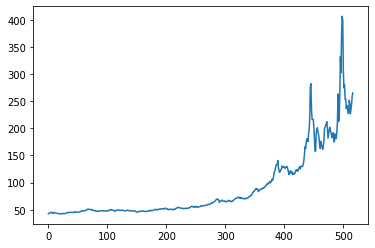

In [59]:
quantiles = [0.1, 0.5, 0.9]

t_test = dfe["e_price"].values[-100:] #final hundred points for testing
plt.plot(dfe["e_price"].values)

for q in quantiles:
    model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adadelta')
    model.fit(dfe['e_price'][:-100].values.reshape(-1,1), dfe['e_price'][1:-99].values.reshape(-1,1), epochs=10, batch_size=1, verbose=0)
    
    # Predict the quantile
    y_test = model.predict(t_test)
    plt.plot(t_test, y_test, label=q) # plot out this quantile

plt.legend()    
plt.show()

0.7746019196318674

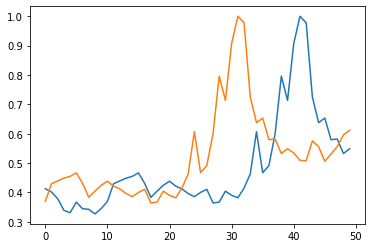

In [17]:
plt.plot(elecs_norm.shift(10)[-50:].values)
plt.plot(elecs_norm[-50:].values)
sklearn.metrics.r2_score(elecs_norm.shift(10)[10:],elecs_norm[10:])

In [20]:
sklearn.metrics.mean_squared_error(elecs_norm.shift(1)[1:],elecs_norm[1:])

0.0006552348576339476